# Accelerometer Log Visualizer
I programmed an Arduino to collect accelerometer data and dump into an SD card as a CSV.  The file format is

(sec since on), (x_last_reading), (y_last_reading), (z_last_reading), (x_reading), (y_reading), (z_reading)

The data only gets logged if last reading is past a certain threshold from first reading

## Generate some random data to test log visualizer

In [24]:
if False:
    import csv
    import random
    tsec = 0;
    with open('tmp.csv', 'w') as csvfile:
        for x in range(0,100):
            tsec = random.randint(tsec, tsec+3600)
            if tsec >= 60*60*8:
                break;
            spamwriter = csv.writer(csvfile)
            spamwriter.writerow([tsec,
                                 random.randint(50,110),
                                 random.randint(50,110),
                                 random.randint(50,110),
                                 random.randint(50,110),
                                 random.randint(50,110),
                                 random.randint(50,110)])

## Read the log data
Read in CSV and store as magnitude of tuple-2 of (hour in float, magnitude of change)

In [43]:
import csv
import numpy as np

fn = "/Users/jpien/Desktop/datalog_2015_05_20__22_00__23_30.csv"
fn = "/Users/jpien/Desktop/datalog_2015_05_25__23_45.csv"
data_log = []
start_hr = 21.15 # 9:15pm
ignore_first_hours = 1.5
with open(fn, 'r') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        sec = long(row[0])
        last = np.array(map(float, row[1:4]))
        cur = np.array(map(float, row[4:]))
        hr = float(sec)/3600.0 
        diff_vec = last-cur
        mag = np.linalg.norm(diff_vec)        
        data_log.append((hr,mag))
    data_log = np.array(data_log)
    
# Is the first entry larger than 2nd?  If so, we have our start time
# in the first entry
# IE 85500,0.1,0,0
if data_log[0][0] > data_log[1][0]:
    start_hr = data_log[0][0]
    ignore_first_hours = data_log[0][1]
    data_log = data_log[1:]

## Combine the magnitudes of readings within the same time quanta

In [44]:
# Find last second
[nr, nc] = np.shape(data_log)
last_min_omit = data_log[nr-1,0]-0.08

#print data_log
accum_row = [data_log[0,0], data_log[0,1]]
new_data_log = [np.copy(accum_row)] # We want first sample
for row in data_log:
    cur_hr = row[0]
    movement = row[1]
    
    # Time from last time is less than 1.5 seconds away
    if np.abs(cur_hr - accum_row[0]) < 0.003:
        # Sum the movement
        accum_row[1] += movement
    else:
        #Ignore the first 15 minutes and 5 minutes
        if accum_row[0] > ignore_first_hours and \
            accum_row[0] < last_min_omit:
            # New entry
            new_data_log.append(accum_row)
        # Start new entry    
        accum_row = [cur_hr, movement]
        
# Last entry with zero movement since there's a lot of movement before we stop data acquisition
new_data_log.append([accum_row[0], 0])
        
data_log = np.array(new_data_log)
#print data_log

## Plot the data plots to see when we made movements

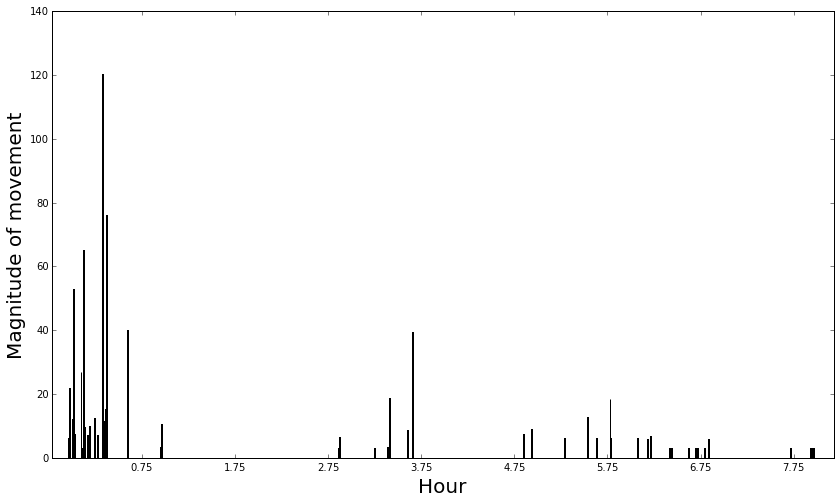

In [45]:
%matplotlib inline

import matplotlib.pyplot as plt
#plt.plot(data_log[:,0],data_log[:,1])
#plt.show()
max_hr = np.max(data_log[:,0]) + 1
fig = plt.figure()
fig.set_size_inches(14, 8)
plt.xticks(np.arange(0,max_hr), np.arange(start_hr,start_hr+max_hr)%24)
plt.bar(data_log[:,0],data_log[:,1], width=0.01)
plt.xlabel("Hour", fontsize = 20)
plt.ylabel("Magnitude of movement", fontsize = 20)
plt.show()
